# Bike Sharing Demand Prediction with AutoGluon

### Install packages

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

In [3]:
!pip install kaggle

In [102]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import json

%matplotlib inline

## 1. Download the Kaggle dataset

In [115]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [116]:
# Fill in your user name and key from creating the kaggle account and API token file
kaggle_username = "uyangas"
kaggle_key = "d1e406b22b8c18b484fffe948a4cb19f"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [ ]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

Data column explanations:

- `datetime` - hourly date + timestamp  
- `season` -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- `holiday` - whether the day is considered a holiday
- `workingday` - whether the day is neither a weekend nor holiday
- `weather` - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- `temp` - temperature in Celsius
- `atemp` - "feels like" temperature in Celsius
- `humidity` - relative humidity
- `windspeed` - wind speed
- `casual` - number of non-registered user rentals initiated
- `registered` - number of registered user rentals initiated
- `count` - number of total rentals

In [156]:
# load the data
train = pd.read_csv('/root/cd0385-project-starter/project/train.csv')
test = pd.read_csv('/root/cd0385-project-starter/project/test.csv')
submission = pd.read_csv('/root/cd0385-project-starter/project/sampleSubmission.csv')

In [17]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [18]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


The `train` dataframe doesn't contain any missing values. The size of the dataframe is `12 columns` and `10886 rows`. The `datetime` column was imported as an object which should be converted to datetime type. There are several columns e.g. `season`, `holiday` and `workingday` were imported as integers but needs further investigation on the datatype.

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


For `test` dataframe, it contains `9 columns` and `6492 rows`. The dataframe doesn't contain any missing values. The `casual` and `registered` columns from `train` dataset are missing in the `test` dataframe. As `train` dataframe, `datetime` column was imported as an object and `season`, `holiday` and `workingday` columns were imported as integers.

In [21]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [24]:
train[['temp','atemp','humidity','windspeed']].corr()

,temp,atemp,humidity,windspeed
temp,1.000000,0.984948,-0.064949,-0.017852
atemp,0.984948,1.000000,-0.043536,-0.057473
humidity,-0.064949,-0.043536,1.000000,-0.318607
windspeed,-0.017852,-0.057473,-0.318607,1.000000


From the table above, `holiday` and `workingday` columns appear to be dummy columns e.g. only contain values 0 and 1. As for `weather` and `season` columns contain values form 1 to 4 which indicates the columns are categorical. `temp` and `atemp` are highly correlated given atemp is adjusted value of temp. The range of `temp` values vary from min 0.82 to 41.0 which might require scaling. `humidity` column takes value from 0 to 100 and `windspeed` takes value from 0 to 57. `casual` and `registered` columns take values ranging from 0 to 886, therefore, need scaling.

In [22]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


As for `test` data, the columns show same characteristics as the `train` data. `atemp` column seems to have slightly higher upper bound value.

In [20]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 8.97MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [117]:
import pandas as pd
from autogluon.tabular import TabularPredictor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv')
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.

In [5]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv')
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [6]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv')
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [8]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [9]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


## 2. Baseline model using AutoGluon’s Tabular Prediction

### 2.1. Baseline model training

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [25]:
predictor = TabularPredictor(label='count', 
                             problem_type='regression',
                             eval_metric='root_mean_squared_error').fit(train.drop(['casual','registered','datetime'],axis=1), 
                                                                        time_limit=600, 
                                                                        presets='best_quality'
                                                                       )

No path specified. Models will be saved in: "AutogluonModels/ag-20221213_190715/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20221213_190715/"
AutoGluon Version:  0.6.0
Python Version:     3.8.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Sep 29 01:01:23 UTC 2022
Train Data Rows:    10886
Train Data Columns: 8
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2902.54 MB
	Train Data (Original)  Memory Usage: 0.7 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: 

In [26]:
model_summary = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -139.684002       6.104714  476.611592                0.000840           0.369035            3       True         19
1     ExtraTreesMSE_BAG_L2 -140.237330       5.621511  380.940515                0.589135           7.902854            2       True         17
2          CatBoost_BAG_L2 -140.837533       5.089679  412.186732                0.057303          39.149071            2       True         16
3        LightGBMXT_BAG_L2 -141.138238       5.352567  394.694003                0.320192          21.656342            2       True         13
4   NeuralNetFastAI_BAG_L2 -141.472205       5.457436  429.190633                0.425060          56.152972            2       True         18
5      WeightedEnsemble_L2 -141.595855       4.073966  348.856305         

/usr/local/lib/python3.8/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


<AxesSubplot: xlabel='model'>

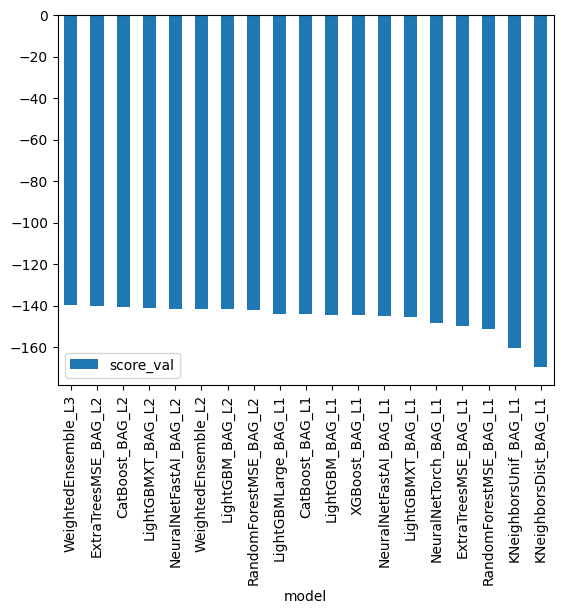

In [27]:
predictor.leaderboard(silent=True).plot(kind='bar',x='model',y='score_val')

Based on the training summary, `WeightedEnsemble_L3` model performed the best compared to the other models.

### 2.2. Prediction of the test set

In [ ]:
print("Number of predictions equal 0:", sum(predictions==0))
print("Number of predictions greater than 0:", sum(predictions>0))
print("Number of predictions less than 0:", sum(predictions<0))
# set the negative predictions to 0
predictions[predictions<0]==0

Number of predictions equal 0: 0
Number of predictions greater than 0: 6493
Number of predictions less than 0: 0


Series([], Name: count, dtype: bool)

In [28]:
predictions = predictor.predict(test.drop('datetime', axis=1))
predictions.head()

0    131.757324
1     76.451378
2     76.451378
3     75.551384
4     75.551384
Name: count, dtype: float32

### 2.3. Submit the predictions to kaggle

In [30]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [31]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 339kB/s]
Successfully submitted to Bike Sharing Demand

View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [32]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv               2022-12-13 19:22:30  first raw submission  complete  1.32753      1.32753       
submission_new_features.csv  2022-12-12 18:54:12  new features          complete  0.69453      0.69453       
submission.csv               2022-12-12 18:27:29  first raw submission  complete  1.32503      1.32503       


Initial score of `1.32753`

## 3. Feature engineered model

### 3.1. Exploratory Data Analysis and Creating an additional feature

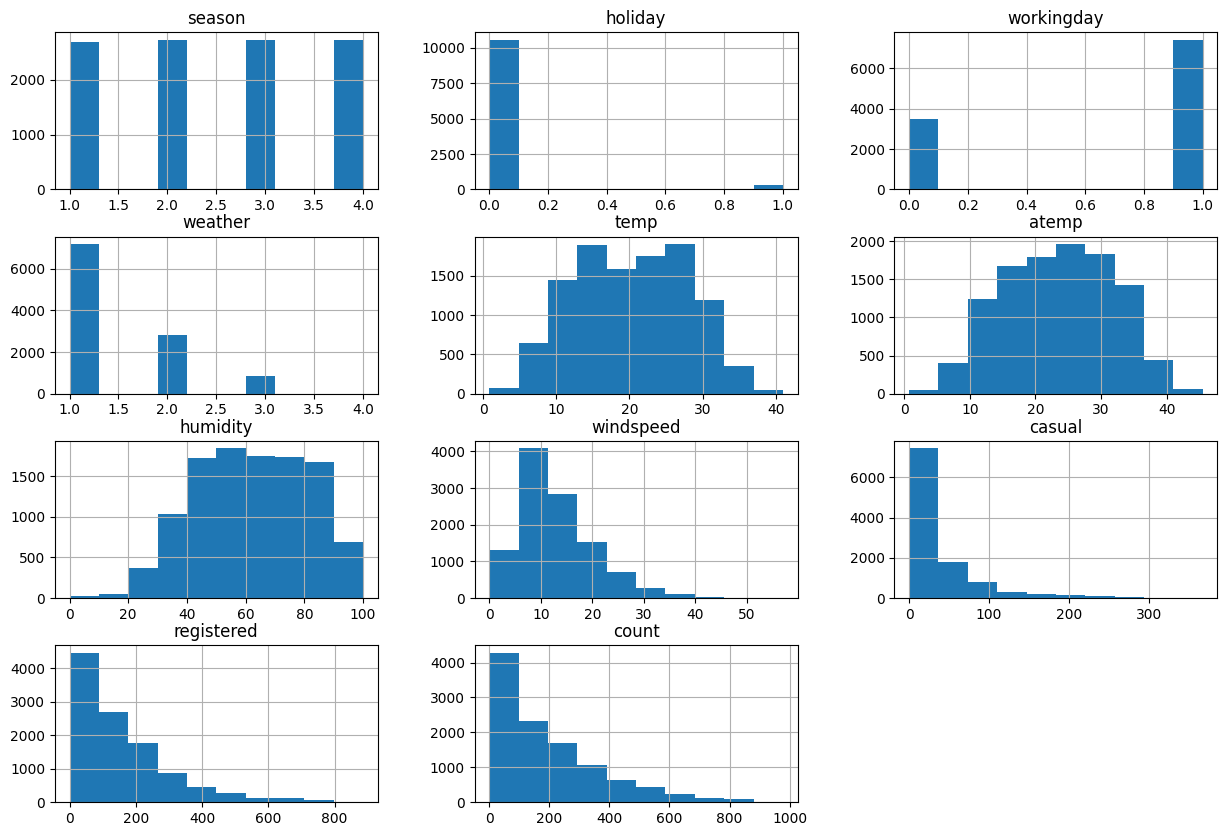

In [68]:
hist = train.hist(figsize=(15,10))
plt.show()

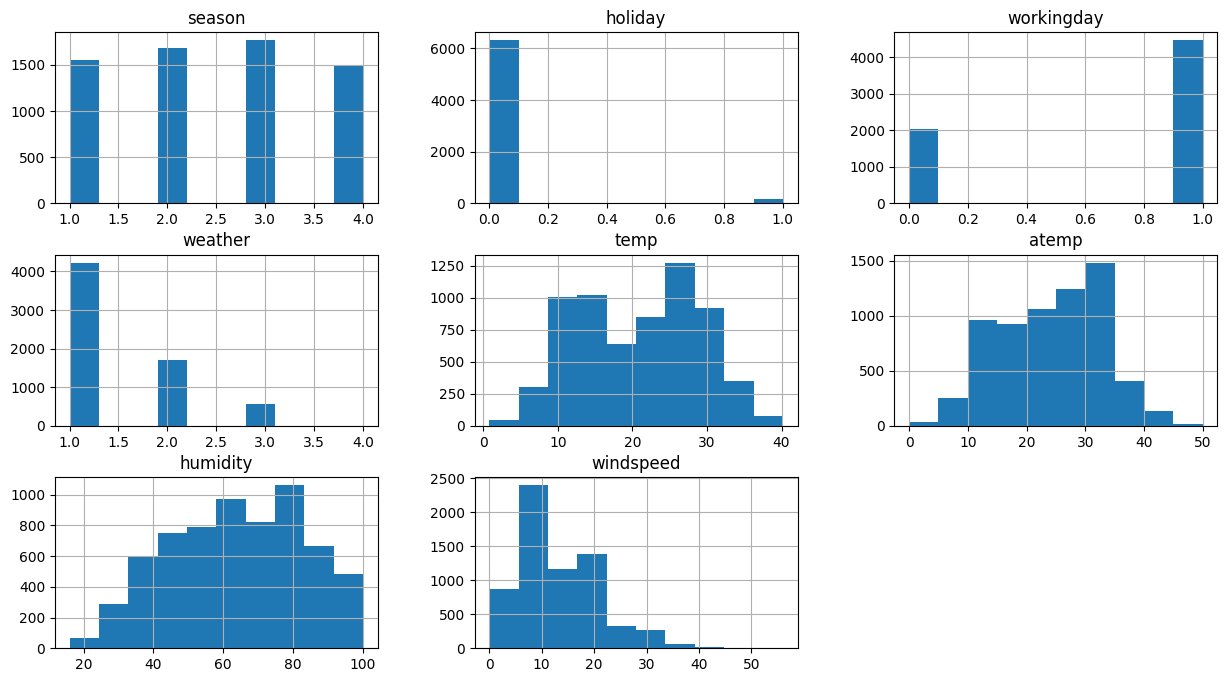

In [69]:
hist = test.hist(figsize=(15,8))
plt.show()

Based on the histograms above, `season`, `weather`, `workingday` and `holiday` variables have similar distribution in both `train` and `test` sets. As for `temp` and `atemp` variables, the distribution in `test` set is slightly different from `train` data. In the `train` data, `humidity` is more pushed to the right side or slightly left skewed, as for `test` data, the shape almost resembles normal distribution. As for `windspeed`, in the `train` data, it's right skewed, as for the `test` set the skeweness is slightly less compared to the `train` data.

In [157]:
# create datetime variables
def dateVar(df, date_col='datetime'):
    df[date_col] = pd.to_datetime(df[date_col])
    df['weekday'] = df[date_col].dt.weekday
    df['hour'] = df[date_col].dt.hour
    
    print("Datetime vars created")
    
    return df

In [158]:
train = dateVar(train)
test = dateVar(test)

Datetime vars created
Datetime vars created


/tmp/ipykernel_12225/2319798037.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  train.groupby(['weekday', 'hour']).agg({'registered':'mean'}).reset_index().pivot('hour','weekday','registered')\


<AxesSubplot: title={'center': 'Average weekly registered users'}, xlabel='hour'>

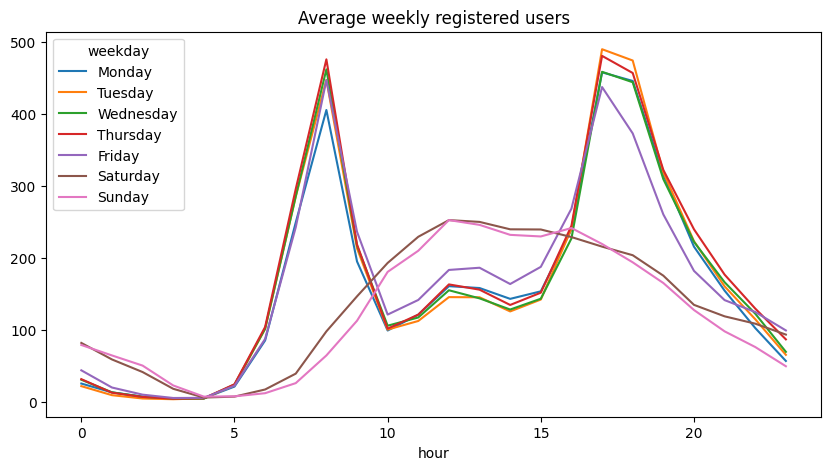

In [159]:
train.groupby(['weekday', 'hour']).agg({'registered':'mean'}).reset_index().pivot('hour','weekday','registered')\
.rename({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'},axis=1)\
.plot(figsize=(10,5), title="Average weekly registered users")

Based on the chart, the average number of registered users have patterns. During workdays, the demand surges during the peak hours in the morning and evening. As for weekends, demand during the day time is higher than that of workdays.

/tmp/ipykernel_12225/618468075.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  train.groupby(['weekday', 'hour']).agg({'casual':'mean'}).reset_index().pivot('hour','weekday','casual')\


<AxesSubplot: title={'center': 'Average weekly casual users'}, xlabel='hour'>

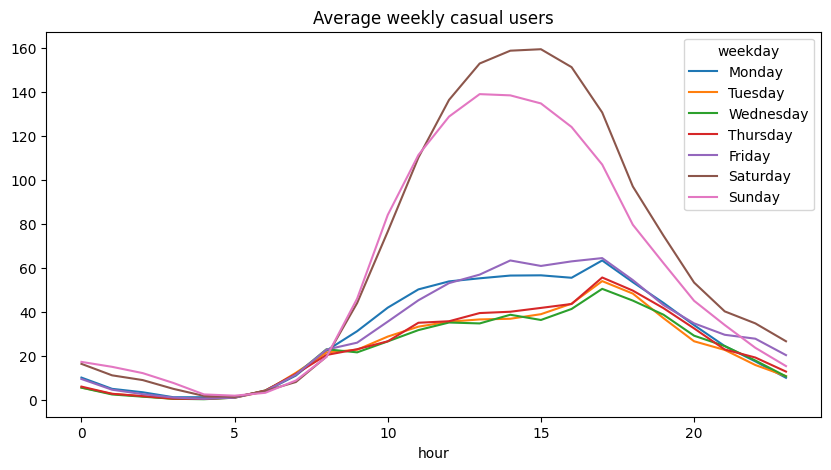

In [160]:
train.groupby(['weekday', 'hour']).agg({'casual':'mean'}).reset_index().pivot('hour','weekday','casual')\
.rename({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'},axis=1)\
.plot(figsize=(10,5), title="Average weekly casual users")

As for casual user demand stayed high during the day time, specifically during the weekend, the demand increases almost 2 times the workday demand. Another interesting observation is that on Monday and Friday, the casual demand tends to be slightly higher than the other workdays.

In [161]:
# add the mean of registered and casual users to the test data
test=test.merge(train.groupby(['weekday','hour']).agg({'casual':'mean','registered':'mean'}).reset_index(),
           on=['weekday','hour'], how='left')
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,weekday,hour,casual,registered
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,3,0,6.246154,31.230769
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,3,1,2.984615,12.430769
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,3,2,1.906250,6.515625
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,3,0.786885,4.081967
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,4,0.650794,4.650794


In [162]:
# convert datatypes
def varAstype(df, cat_cols=['season','weather','workingday','holiday']):
    for col in cat_cols:
        df[col]=df[col].astype('category')
        
    print("The categorical columns are converted")
    
    return df

In [163]:
train=varAstype(train)
test=varAstype(test)

The categorical columns are converted
The categorical columns are converted


In [129]:
# View the new features
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,weekday,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,5,4


In [164]:
# scaled the numerical variables
train1 = train.copy()
test1 = test.copy()
num_cols=['casual','registered','atemp','humidity']
st_scaler=StandardScaler()
train1[num_cols] = st_scaler.fit_transform(train1[num_cols])
test1[num_cols] = st_scaler.transform(test1[num_cols])

In [165]:
train1.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,weekday,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,-1.092737,0.993213,0.0,-0.660992,-0.943854,16,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,-1.182421,0.941249,0.0,-0.560908,-0.818052,40,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,-1.182421,0.941249,0.0,-0.620958,-0.851158,32,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,-1.092737,0.681430,0.0,-0.660992,-0.963717,13,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,-1.092737,0.681430,0.0,-0.721042,-1.023307,1,5,4


In [166]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  category      
 3   workingday  10886 non-null  category      
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  float64       
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  float64       
 10  registered  10886 non-null  float64       
 11  count       10886 non-null  int64         
 12  weekday     10886 non-null  int64         
 13  hour        10886 non-null  int64         
dtypes: category(4), datetime64[ns](1), float64(6), int64(3)
memory usage: 893.8 KB


### 3.2. Re-train the model on feature engineered data

In [279]:
predictor_new_features = TabularPredictor(label='count', 
                                          problem_type='regression',
                                          eval_metric='root_mean_squared_error')\
.fit(train1.drop(['datetime','temp'],axis=1), 
     time_limit=600, 
     presets='best_quality'
    )

No path specified. Models will be saved in: "AutogluonModels/ag-20221214_011805/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20221214_011805/"
AutoGluon Version:  0.6.0
Python Version:     3.8.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Sep 29 01:01:23 UTC 2022
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1398.36 MB
	Train Data (Original)  Memory Usage: 0.65 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note

In [281]:
model_summary_new_feature = predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -1.677534      59.365579  540.670959                0.000791           0.293403            3       True         14
1   RandomForestMSE_BAG_L2  -1.749076      45.563606  404.995768                0.401711          17.223220            2       True         12
2      WeightedEnsemble_L2  -1.956372      44.950229  388.365559                0.001162           0.654691            2       True          9
3          LightGBM_BAG_L2  -2.144379      46.064181  419.691325                0.902286          31.918777            2       True         11
4     ExtraTreesMSE_BAG_L1  -2.430052       0.559490    3.708801                0.559490           3.708801            1       True          7
5   RandomForestMSE_BAG_L1  -2.713098       0.483300    8.302209                

/usr/local/lib/python3.8/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


<AxesSubplot: xlabel='model'>

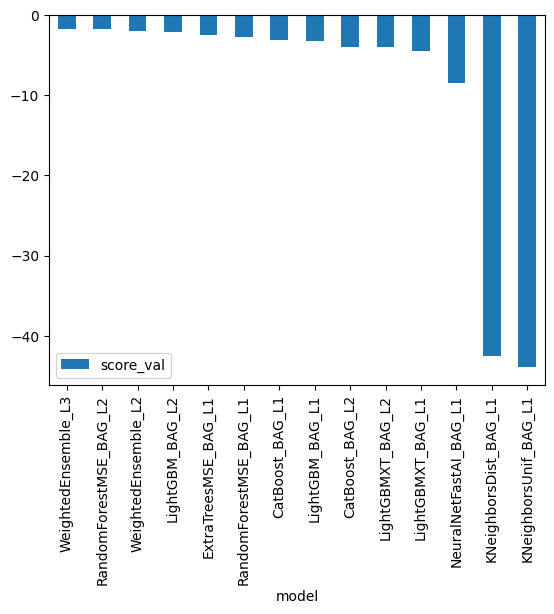

In [282]:
predictor_new_features.leaderboard(silent=True).plot(kind='bar',x='model',y='score_val')

### 3.3. Submit the predictions to kaggle

In [283]:
# Remember to set all negative values to zero
predictions_new_features = predictor_new_features.predict(test1.drop('datetime', axis=1))
print("Number of predictions equal 0:", sum(predictions_new_features==0))
print("Number of predictions greater than 0:", sum(predictions_new_features>0))
print("Number of predictions less than 0:", sum(predictions_new_features<0))
# set the negative predictions to 0
predictions_new_features[predictions_new_features<0]==0

Number of predictions equal 0: 0
Number of predictions greater than 0: 6493
Number of predictions less than 0: 0


Series([], Name: count, dtype: bool)

In [284]:
# Submitting predictions
submission_new_features = submission.copy()
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [285]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 384kB/s]
Successfully submitted to Bike Sharing Demand

In [286]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2022-12-14 01:30:36  new features          complete  0.69486      0.69486       
submission_new_hpo2.csv      2022-12-14 01:17:07  new features hpo2     complete  1.32753      1.32753       
submission_new_hpo1.csv      2022-12-14 01:15:26  new features hpo1     complete  1.54961      1.54961       
submission_new_hpo2.csv      2022-12-14 01:13:25  new features hpo2     error                                


New Score of `0.69489`

## 4. Hyper parameter optimized models
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

__Main Parameters:__

- `target`: `count`
- `metric`: `root_mean_squared_error`
- `presets`: `best_quality`

### 4.1. Optimization 1

The following parameters were changed:
1. `time_limit`: `15*60 (900)`
1. `num_bag_folds`:`2` 
1. `num_bag_sets`:`2`

In [288]:
predictor_new_hpo = TabularPredictor(label='count', 
                                      problem_type='regression',
                                      eval_metric='root_mean_squared_error')\
.fit(train1.drop(['datetime','temp'], axis=1), 
     time_limit=900, 
     presets='best_quality',
     num_bag_folds=2
    )

No path specified. Models will be saved in: "AutogluonModels/ag-20221214_013212/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=2, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels/ag-20221214_013212/"
AutoGluon Version:  0.6.0
Python Version:     3.8.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Sep 29 01:01:23 UTC 2022
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1394.55 MB
	Train Data (Original)  Memory Usage: 0.65 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note

In [289]:
model_summary_hpo1 = predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -1.649994      55.575770  488.200701                0.001413           0.684595            3       True         21
1     ExtraTreesMSE_BAG_L2  -1.668257      54.576479  431.771651                0.508129           5.891291            2       True         17
2   RandomForestMSE_BAG_L2  -1.729530      54.479753  447.559135                0.411403          21.678776            2       True         15
3      WeightedEnsemble_L2  -1.984821      50.441415  390.458078                0.001274           0.817397            2       True         12
4     ExtraTreesMSE_BAG_L1  -2.453946       0.388326    3.558415                0.388326           3.558415            1       True          7
5          LightGBM_BAG_L2  -2.703411      54.220828  429.171847                

/usr/local/lib/python3.8/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


<AxesSubplot: xlabel='model'>

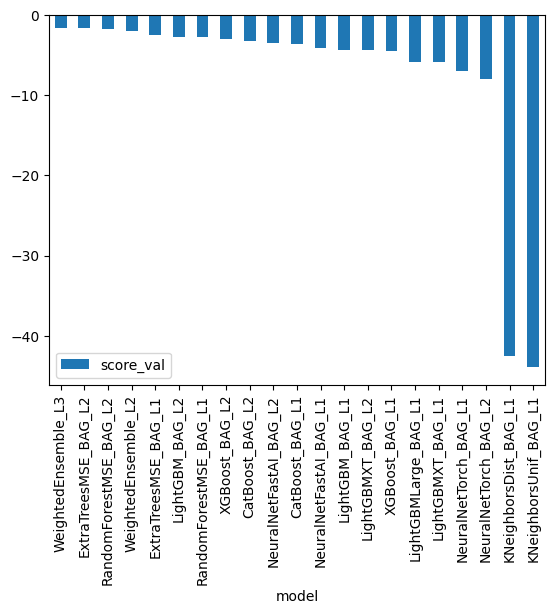

In [290]:
predictor_new_hpo.leaderboard(silent=True).plot(kind='bar',x='model',y='score_val')

In [291]:
# submit to kaggle
submission_name="submission_new_hpo1.csv"

predictions_hpo1 = predictor_new_hpo.predict(test1.drop('datetime', axis=1))
print("Number of predictions equal 0:", sum(predictions_hpo1==0))
print("Number of predictions greater than 0:", sum(predictions_hpo1>0))
print("Number of predictions less than 0:", sum(predictions_hpo1<0))
# set the negative predictions to 0
predictions_hpo1[predictions_hpo1<0]==0
print("Negative values repalced by 0")

# Submitting predictions
submission_hpo1 = submission.copy()
submission_hpo1["count"] = predictions_hpo1
submission_hpo1.to_csv(submission_name, index=False)

Number of predictions equal 0: 0
Number of predictions greater than 0: 6493
Number of predictions less than 0: 0
Negative values repalced by 0


In [292]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo1.csv -m "new features hpo1"
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 361kB/s]
Successfully submitted to Bike Sharing DemandfileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_hpo1.csv      2022-12-14 01:48:07  new features hpo1     complete  0.69403      0.69403       
submission_new_features.csv  2022-12-14 01:30:36  new features          complete  0.69486      0.69486       
submission_new_hpo2.csv      2022-12-14 01:17:07  new features hpo2     complete  1.32753      1.32753       
submission_new_hpo1.csv      2022-12-14 01:15:26  new features hpo1     complete  1.54961      1.54961       


New Score of `0.69404`

### 4.2. Optimization 2

The following parameters were changed:
1. `time_limit`: `15*60 (900)`
1. `num_bag_folds`:`2` 
1. `num_bag_sets`:`2`

Following features were modified and added:
1. `weekday` converted to `categorical`
1. Removed `casual` and `registered`. Turns out `count`=`casual`+`registered`
1. Added `type_hour` variable: 1-peak hour, 2-night time, and 3-day time
1. Added `year`, `month`, `day` variables

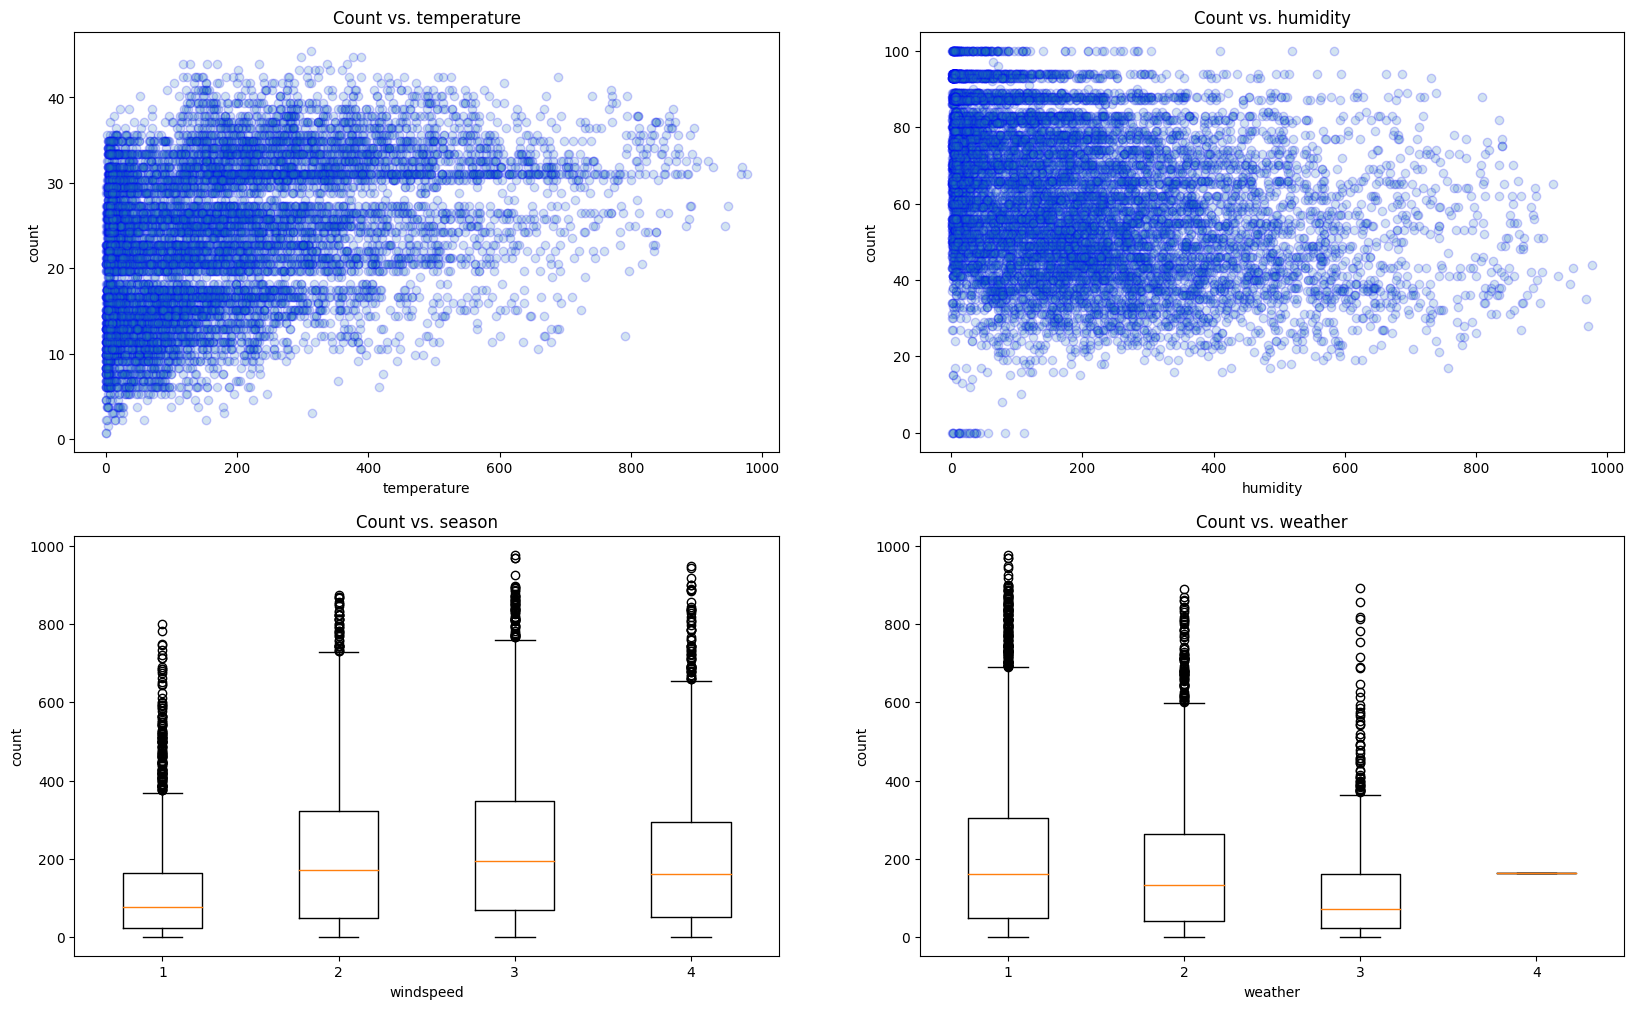

In [221]:
fig, axs = plt.subplots(2,2, figsize=(20,12))
axs[0,0].scatter(x=train[['count']], y=train[['atemp']], alpha=0.2, linewidths=1, edgecolors='blue')
axs[0,1].scatter(x=train[['count']], y=train[['humidity']], alpha=0.2, linewidths=1, edgecolors='blue')
axs[1,0].boxplot([train.query('season==1')['count'],
                  train.query('season==2')['count'], 
                  train.query('season==3')['count'],
                  train.query('season==4')['count']])
axs[1,1].boxplot([train.query('weather==1')['count'],
                  train.query('weather==2')['count'], 
                  train.query('weather==3')['count'],
                  train.query('weather==4')['count']])
axs[0,0].set(xlabel='temperature', ylabel='count',title="Count vs. temperature")
axs[0,1].set(xlabel='humidity', ylabel='count', title="Count vs. humidity")
axs[1,0].set(xlabel='windspeed', ylabel='count', title="Count vs. season")
axs[1,1].set(xlabel='weather', ylabel='count', title="Count vs. weather")

plt.show()

In [233]:
train['weekday'] = train['weekday'].astype('category')
test['weekday'] = test['weekday'].astype('category')

In [260]:
def typeVar(df):
    df['type_hour'] = 3
    df.loc[(df['hour']>=6)&(df['hour']<=9),'type_hour'] = 1
    df.loc[(df['hour']>=15)&(df['hour']<=20),'type_hour'] = 1
    df.loc[(df['hour']>9)&(df['hour']<15),'type_hour'] = 2

    df['type_hour'] = df['type_hour'].astype('category')
    
    return df

In [261]:
train = typeVar(train)
test = typeVar(test)

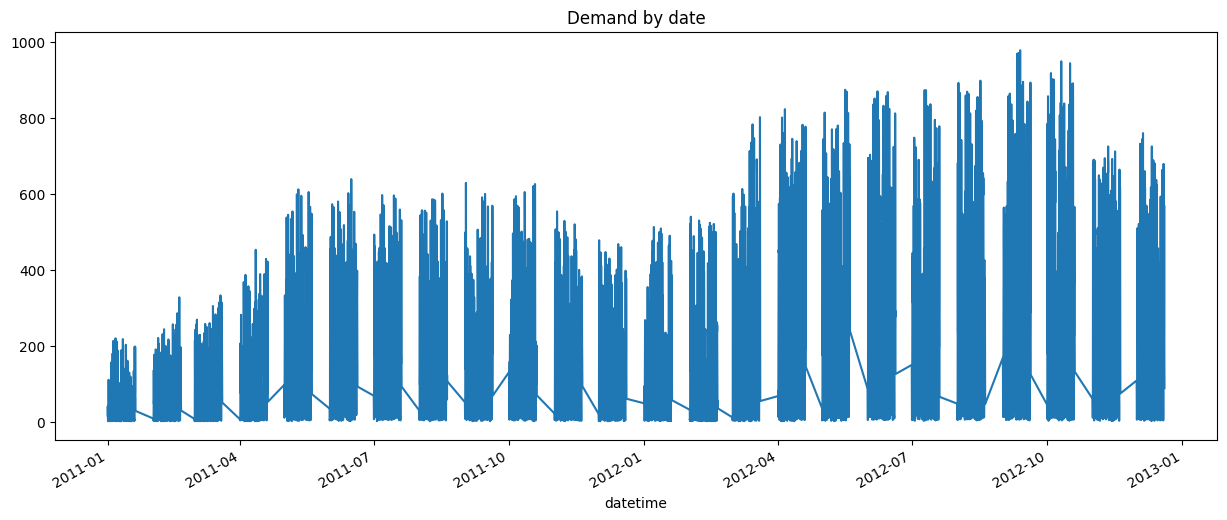

In [250]:
train.set_index('datetime')['count'].plot(figsize=(15,6), title='Demand by date')
None

In [245]:
# create datetime variables
def dateVar2(df, date_col='datetime'):
    df[date_col] = pd.to_datetime(df[date_col])
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    
    print("Datetime vars created")
    
    return df

In [295]:
train = dateVar2(train)
test = dateVar2(test)

Datetime vars created
Datetime vars created


In [296]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,weekday,hour,casual,registered,year,month,day,type_hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,3,0,6.246154,31.230769,2011,1,20,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,3,1,2.984615,12.430769,2011,1,20,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,3,2,1.906250,6.515625,2011,1,20,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,3,0.786885,4.081967,2011,1,20,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,4,0.650794,4.650794,2011,1,20,3


In [297]:
# add the mean of registered and casual users to the test data
train=train.merge(train.groupby(['month','weekday','hour']).agg({'count':'mean'}).reset_index()\
                .rename({'count':'count_mean'},axis=1),
           on=['weekday','hour','month'], how='left')
test=test.merge(train.groupby(['month','weekday','hour']).agg({'count':'mean'}).reset_index()\
                .rename({'count':'count_mean'},axis=1),
           on=['weekday','hour','month'], how='left')
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,weekday,hour,casual,registered,year,month,day,type_hour,count_mean
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,3,0,6.246154,31.230769,2011,1,20,3,10.2
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,3,1,2.984615,12.430769,2011,1,20,3,3.8
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,3,2,1.906250,6.515625,2011,1,20,3,2.6
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,3,0.786885,4.081967,2011,1,20,3,3.5
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,4,0.650794,4.650794,2011,1,20,3,2.6


In [299]:
# scale the numerical columns
num_cols=['casual','registered','count_mean','atemp','humidity']
st_scaler=StandardScaler()
train[num_cols] = st_scaler.fit_transform(train[num_cols])
test[num_cols] = st_scaler.transform(test[num_cols])

In [300]:
df_train, df_val = train_test_split(train, test_size=0.2, random_state=1)
print("Train size: ", df_train.shape)
print("Validation size: ", df_val.shape)

Train size:  (8708, 19)
Validation size:  (2178, 19)


In [ ]:
predictor_new_hpo2 = TabularPredictor(label='count', 
                                          problem_type='regression',
                                          eval_metric='root_mean_squared_error')\
.fit(df_train.drop(['datetime','temp'],axis=1), 
     time_limit=900, 
     presets='best_quality',
     num_bag_folds=2,
     num_bag_sets=2
    )

No path specified. Models will be saved in: "AutogluonModels/ag-20221214_020802/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=2, num_bag_sets=2
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels/ag-20221214_020802/"
AutoGluon Version:  0.6.0
Python Version:     3.8.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Sep 29 01:01:23 UTC 2022
Train Data Rows:    8708
Train Data Columns: 16
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1392.35 MB
	Train Data (Original)  Memory Usage: 0.75 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: 

In [309]:
model_summary_hpo2 = predictor_new_hpo2.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -0.009768      53.967520  500.218476                0.000984           0.430439            3       True         21
1     ExtraTreesMSE_BAG_L2  -0.010046      53.295914  463.422251                0.487746           6.143545            2       True         17
2   RandomForestMSE_BAG_L2  -0.010185      53.190730  477.761520                0.382562          20.482813            2       True         15
3      WeightedEnsemble_L2  -0.013049       2.236297  341.136763                0.001453           0.608998            2       True         12
4   RandomForestMSE_BAG_L1  -0.017828       0.520564    9.287452                0.520564           9.287452            1       True          5
5   NeuralNetFastAI_BAG_L2  -0.017854      53.096228  473.161680                

/usr/local/lib/python3.8/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


<AxesSubplot: xlabel='model'>

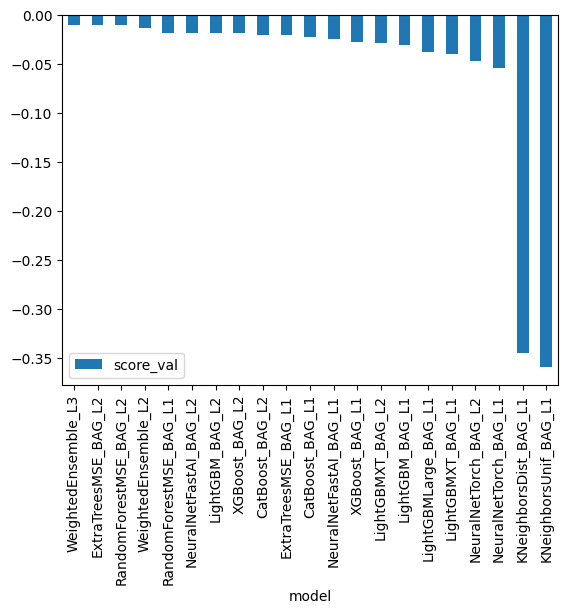

In [321]:
predictor_new_hpo2.leaderboard(silent=True).plot(kind='bar',x='model',y='score_val')

In [312]:
# submit to kaggle
submission_name="submission_new_hpo2.csv"

predictions_hpo2 = predictor_new_hpo2.predict(test.drop(['datetime','temp'], axis=1))
print("Number of predictions equal 0:", sum(predictions_hpo2==0))
print("Number of predictions greater than 0:", sum(predictions_hpo2>0))
print("Number of predictions less than 0:", sum(predictions_hpo2<0))
# set the negative predictions to 0
predictions_hpo2[predictions_hpo2<0]==0
print("Negative values replaced by 0")

# Submitting predictions
submission_hpo2 = submission.copy()
submission_hpo2["count"] = predictions_hpo2
submission_hpo2.to_csv(submission_name, index=False)

Number of predictions equal 0: 0
Number of predictions greater than 0: 6493
Number of predictions less than 0: 0
Negative values replaced by 0


In [314]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo2.csv -m "new features hpo2"
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

100%|█████████████████████████████████████████| 187k/187k [00:00<00:00, 397kB/s]
Successfully submitted to Bike Sharing DemandfileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_hpo2.csv      2022-12-14 03:39:37  new features hpo2     complete  2.96573      2.96573       
submission_new_hpo2.csv      2022-12-14 02:03:03  new features hpo2     error                                
submission_new_hpo1.csv      2022-12-14 01:48:07  new features hpo1     complete  0.69403      0.69403       
submission_new_features.csv  2022-12-14 01:30:36  new features          complete  0.69486      0.69486       


### 4.3. Optimization 3

The following parameters were changed:
1. `time_limit`:`900`
1. `num_bag_folds`:`3` 
1. `num_bag_sets`:`2`
1. `num_stack_levels`:`1`

The features were not changed from `Optimization2`.

In [319]:
predictor_new_hpo3 = TabularPredictor(label='count', 
                                          problem_type='regression',
                                          eval_metric='root_mean_squared_error')\
.fit(df_train.drop(['datetime','temp'],axis=1), 
     time_limit=900, 
     presets='best_quality',
     num_bag_folds=3,
     num_bag_sets=2,
     num_stack_levels=1
    )

No path specified. Models will be saved in: "AutogluonModels/ag-20221214_195449/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=3, num_bag_sets=2
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels/ag-20221214_195449/"
AutoGluon Version:  0.6.0
Python Version:     3.8.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Sep 29 01:01:23 UTC 2022
Train Data Rows:    8708
Train Data Columns: 16
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1462.41 MB
	Train Data (Original)  Memory Usage: 0.75 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: 

In [322]:
model_summary_hpo3 = predictor_new_hpo3.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -0.009882      32.184935  621.232081                0.000929           0.568064            3       True         19
1   RandomForestMSE_BAG_L2  -0.010209      31.436195  588.765682                0.382588          20.741467            2       True         15
2     ExtraTreesMSE_BAG_L2  -0.010298      31.512581  573.913881                0.458974           5.889665            2       True         17
3      WeightedEnsemble_L2  -0.012538      29.985986  491.714329                0.000698           0.555935            2       True         12
4          LightGBM_BAG_L2  -0.015007      31.170119  575.633197                0.116512           7.608981            2       True         14
5   RandomForestMSE_BAG_L1  -0.017828       0.453235    9.358052                

/usr/local/lib/python3.8/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


<AxesSubplot: xlabel='model'>

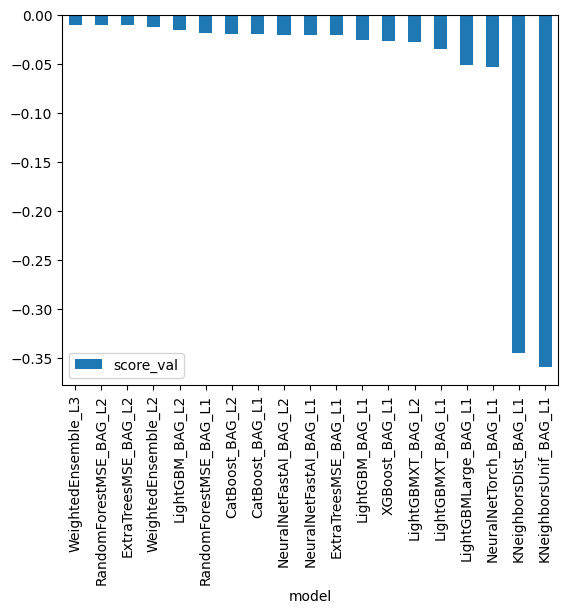

In [320]:
predictor_new_hpo3.leaderboard(silent=True).plot(kind='bar',x='model',y='score_val')

In [323]:
# submit to kaggle
submission_name="submission_new_hpo3.csv"

predictions_hpo3 = predictor_new_hpo3.predict(test.drop(['datetime','temp'], axis=1))
print("Number of predictions equal 0:", sum(predictions_hpo3==0))
print("Number of predictions greater than 0:", sum(predictions_hpo3>0))
print("Number of predictions less than 0:", sum(predictions_hpo3<0))
# set the negative predictions to 0
predictions_hpo3[predictions_hpo3<0]==0
print("Negative values replaced by 0")

# Submitting predictions
submission_hpo3 = submission.copy()
submission_hpo3["count"] = predictions_hpo3
submission_hpo3.to_csv(submission_name, index=False)

Number of predictions equal 0: 0
Number of predictions greater than 0: 6493
Number of predictions less than 0: 0
Negative values replaced by 0


In [324]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo3.csv -m "new features hpo3"
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

100%|█████████████████████████████████████████| 187k/187k [00:00<00:00, 401kB/s]
Successfully submitted to Bike Sharing DemandfileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_hpo3.csv      2022-12-14 20:12:16  new features hpo3     complete  3.03139      3.03139       
submission_new_hpo2.csv      2022-12-14 03:39:37  new features hpo2     complete  2.96573      2.96573       
submission_new_hpo2.csv      2022-12-14 02:03:03  new features hpo2     error                                
submission_new_hpo1.csv      2022-12-14 01:48:07  new features hpo1     complete  0.69403      0.69403       


## Appendix: 

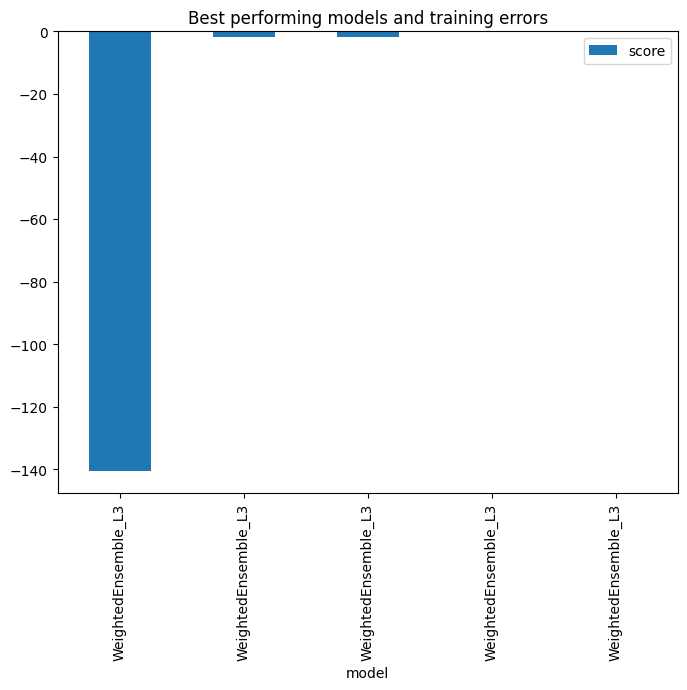

In [330]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["WeightedEnsemble_L3", "WeightedEnsemble_L3", "WeightedEnsemble_L3","WeightedEnsemble_L3","WeightedEnsemble_L3"],
        "score": [-140.69, -1.64, -1.64, -0.009, -0.009]
    }
).plot(x="model", y="score", figsize=(8, 6), kind='bar', title="Best performing models and training errors").get_figure()
fig.savefig('model_train_score.png')

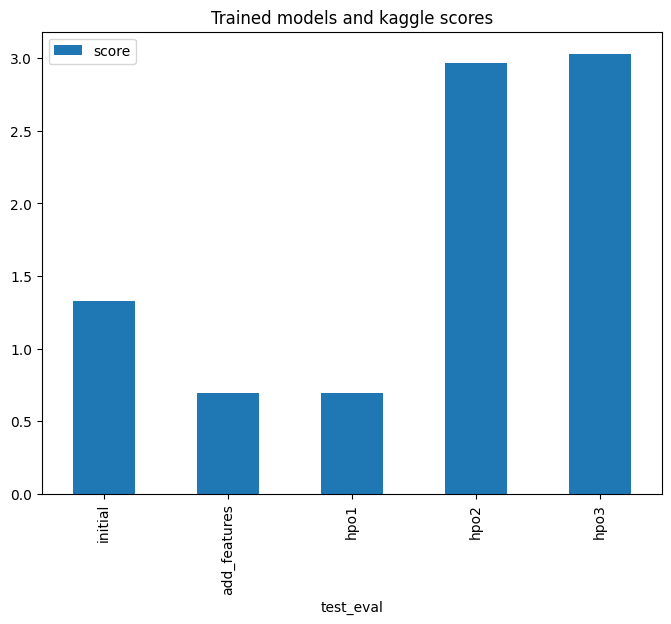

In [331]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo1","hpo2","hpo3"],
        "score": [1.327, 0.695, 0.694, 2.965, 3.031]
    }
).plot(x="test_eval", y="score", figsize=(8, 6), kind='bar', title="Trained models and kaggle scores").get_figure()
fig.savefig('model_test_score.png')

The end of the notebook